In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imb_Pipeline

In [5]:
df = pd.read_csv('Fraud Detection Dataset.csv')

In [6]:
numeric_cols = ['Transaction_Amount', 'Time_of_Transaction', 
               'Previous_Fraudulent_Transactions', 'Account_Age', 
               'Number_of_Transactions_Last_24H']
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

In [7]:
categorical_cols = ['Transaction_Type', 'Device_Used', 'Location', 'Payment_Method']
for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')

In [8]:
print(f"Dataset shape: {df.shape}")
print("\nMissing values after cleaning:")
print(df.isnull().sum())
print("\nFraud distribution:")
print(df['Fraudulent'].value_counts(normalize=True))


Dataset shape: (51000, 12)

Missing values after cleaning:
Transaction_ID                      0
User_ID                             0
Transaction_Amount                  0
Transaction_Type                    0
Time_of_Transaction                 0
Device_Used                         0
Location                            0
Previous_Fraudulent_Transactions    0
Account_Age                         0
Number_of_Transactions_Last_24H     0
Payment_Method                      0
Fraudulent                          0
dtype: int64

Fraud distribution:
Fraudulent
0    0.950784
1    0.049216
Name: proportion, dtype: float64


In [9]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)])

In [10]:
X = df.drop(['Fraudulent', 'Transaction_ID', 'User_ID'], axis=1)
y = df['Fraudulent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                   random_state=42, 
                                                   stratify=y)

In [11]:
model = imb_Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=100, 
                                        random_state=42,
                                        class_weight='balanced'))
])


In [12]:
model.fit(X_train, y_train)

C:\Users\Rajeev\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Rajeev\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\Rajeev\anaconda3\lib\subprocess.py", line 493, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\Rajeev\anaconda3\lib\subprocess.py", line 858, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Rajeev\anaconda3\lib\subprocess.py", line 1311, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Transaction_Amount',
                                                   'Time_of_Transaction',
                                                   'Previous_Fraudulent_Transactions',
                                                   'Account_Age',
                                                   'Number_of_Transactions_Last_24H']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Transaction_Type',
                                                   'Device_Used', 'Location',
                                                   'Payment_Method'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [13]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [14]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     14547
           1       0.48      0.03      0.06       753

    accuracy                           0.95     15300
   macro avg       0.72      0.51      0.52     15300
weighted avg       0.93      0.95      0.93     15300


Confusion Matrix:
[[14522    25]
 [  730    23]]

ROC AUC Score: 0.5284


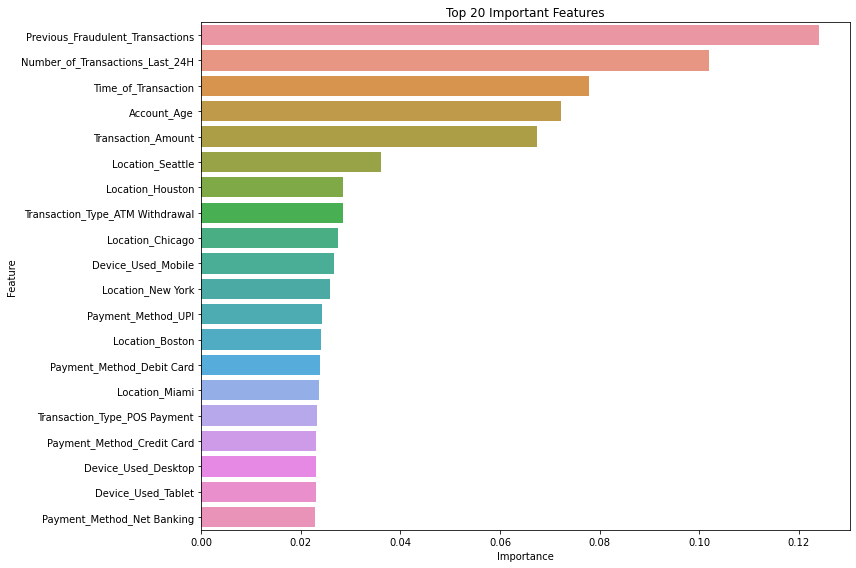

In [15]:
try:
    rf_model = model.named_steps['classifier']
    onehot_columns = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)
    all_features = numeric_cols + list(onehot_columns)
    features_df = pd.DataFrame({'Feature': all_features, 'Importance': rf_model.feature_importances_})
    features_df = features_df.sort_values('Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=features_df.head(20))
    plt.title('Top 20 Important Features')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"\nCould not plot feature importance: {e}")


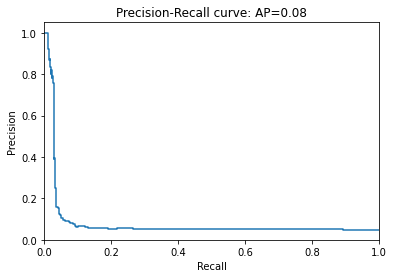

In [16]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall curve: AP={average_precision:.2f}')
plt.show()

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                           precision_recall_curve, average_precision_score, 
                           f1_score, recall_score, precision_score)
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imb_Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

TypeError: 'type' object is not subscriptable

In [28]:
def load_and_preprocess(filepath):
    df = pd.read_csv(filepath)
    
    # Feature Engineering
    df['Amount_per_Transaction_24H'] = df['Transaction_Amount'] / (df['Number_of_Transactions_Last_24H'] + 1)
    df['Transaction_Amount_to_Account_Age'] = df['Transaction_Amount'] / (df['Account_Age'] + 1)
    df['Hour_of_Day'] = df['Time_of_Transaction'] % 24
    df['Is_Weekend'] = ((df['Time_of_Transaction'] // 24) % 7 >= 5).astype(int)
    
    # Handle missing values
    numeric_cols = ['Transaction_Amount', 'Time_of_Transaction', 
                   'Previous_Fraudulent_Transactions', 'Account_Age', 
                   'Number_of_Transactions_Last_24H',
                   'Amount_per_Transaction_24H', 'Transaction_Amount_to_Account_Age',
                   'Hour_of_Day']
    
    categorical_cols = ['Transaction_Type', 'Device_Used', 'Location', 'Payment_Method', 'Is_Weekend']
    
    for col in numeric_cols:
        df[col] = df[col].fillna(df[col].median())
    
    for col in categorical_cols:
        df[col] = df[col].fillna('Unknown')
    
    return df, numeric_cols, categorical_cols

In [29]:
def create_preprocessor(numeric_cols, categorical_cols):
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())  # More robust to outliers than StandardScaler
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])
    
    return preprocessor

In [30]:
def train_models(X_train, y_train, preprocessor):
    models = {
        'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=42),
        'XGBoost': XGBClassifier(scale_pos_weight=sum(y_train==0)/sum(y_train==1), 
                                eval_metric='aucpr', random_state=42),
        'LightGBM': LGBMClassifier(class_weight='balanced', random_state=42),
        'LogisticRegression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
        'SVM': SVC(class_weight='balanced', probability=True, random_state=42)
    }
    
    param_grids = {
        'RandomForest': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [None, 10, 20],
            'classifier__min_samples_split': [2, 5]
        },
        'XGBoost': {
            'classifier__learning_rate': [0.01, 0.1],
            'classifier__max_depth': [3, 6, 9],
            'classifier__subsample': [0.8, 1.0]
        },
        'LightGBM': {
            'classifier__num_leaves': [31, 63],
            'classifier__learning_rate': [0.01, 0.1],
            'classifier__n_estimators': [100, 200]
        }
    }
    
    trained_models = {}
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    for name, model in models.items():
        try:
            pipeline = imb_Pipeline([
                ('preprocessor', preprocessor),
                ('smote', SMOTE(random_state=42)),
                ('classifier', model)
            ])
            
            if name in param_grids:
                grid_search = GridSearchCV(
                    pipeline,
                    param_grids[name],
                    cv=cv,
                    scoring='roc_auc',
                    n_jobs=-1,
                    verbose=1
                )
                grid_search.fit(X_train, y_train)
                trained_models[name] = grid_search.best_estimator_
                print(f"{name} best params: {grid_search.best_params_}")
            else:
                pipeline.fit(X_train, y_train)
                trained_models[name] = pipeline
                
            print(f"{name} training completed")
        except Exception as e:
            print(f"Error training {name}: {e}")
    
    return trained_models

In [31]:
def create_nn_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'AUC', 'Precision', 'Recall']
    )
    
    return model

def train_neural_network(X_train, y_train, preprocessor):
    try:
        # First transform the data to get feature dimension
        X_transformed = preprocessor.fit_transform(X_train)
        input_dim = X_transformed.shape[1]
        
        # Create pipeline
        nn_pipeline = imb_Pipeline([
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('classifier', KerasClassifier(
                build_fn=lambda: create_nn_model(input_dim),
                epochs=50,
                batch_size=256,
                validation_split=0.2,
                callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
                verbose=1
            ))
        ])
        
        nn_pipeline.fit(X_train, y_train)
        return nn_pipeline
    except Exception as e:
        print(f"Error training neural network: {e}")
        return None

In [32]:
def evaluate_models(models, X_test, y_test):
    results = {}
    
    for name, model in models.items():
        try:
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
            
            metrics = {
                'accuracy': np.mean(y_pred == y_test),
                'precision': precision_score(y_test, y_pred),
                'recall': recall_score(y_test, y_pred),
                'f1': f1_score(y_test, y_pred),
                'roc_auc': roc_auc_score(y_test, y_proba) if y_proba is not None else None,
                'pr_auc': average_precision_score(y_test, y_proba) if y_proba is not None else None
            }
            
            results[name] = metrics
            
            print(f"\n{name} Performance:")
            print(classification_report(y_test, y_pred))
            
            # Plot confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(6, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'{name} Confusion Matrix')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.show()
            
            # Plot ROC curve if probabilities available
            if y_proba is not None:
                fpr, tpr, _ = roc_curve(y_test, y_proba)
                plt.figure()
                plt.plot(fpr, tpr, label=f'{name} (AUC = {metrics["roc_auc"]:.2f})')
                plt.plot([0, 1], [0, 1], 'k--')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title('ROC Curve')
                plt.legend()
                plt.show()
                
                # Plot Precision-Recall curve
                precision, recall, _ = precision_recall_curve(y_test, y_proba)
                plt.figure()
                plt.step(recall, precision, where='post', label=f'{name} (AP = {metrics["pr_auc"]:.2f})')
                plt.xlabel('Recall')
                plt.ylabel('Precision')
                plt.ylim([0.0, 1.05])
                plt.xlim([0.0, 1.0])
                plt.title('Precision-Recall Curve')
                plt.legend()
                plt.show()
                
        except Exception as e:
            print(f"Error evaluating {name}: {e}")
    
    return pd.DataFrame(results).T

In [35]:
def anomaly_detection(X, y, preprocessor):
    try:
        # Only use normal transactions for training
        X_normal = X[y == 0]
        
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('detector', IsolationForest(
                contamination=float(y.mean()),
                random_state=42,
                n_estimators=200
            ))
        ])
        
        pipeline.fit(X_normal)
        return pipeline
    except Exception as e:
        print(f"Error in anomaly detection: {e}")
        return None

# Main Execution
if __name__ == "__main__":
    # Load and preprocess data
    df, numeric_cols, categorical_cols = load_and_preprocess('Fraud Detection Dataset.csv')
    
    # Split data
    X = df.drop(['Fraudulent', 'Transaction_ID', 'User_ID'], axis=1)
    y = df['Fraudulent']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Create preprocessor
    preprocessor = create_preprocessor(numeric_cols, categorical_cols)
    
    # Train traditional ML models
    print("\nTraining traditional ML models...")
    models = train_models(X_train, y_train, preprocessor)
    
    # Train neural network
    print("\nTraining neural network...")
    nn_model = train_neural_network(X_train, y_train, preprocessor)
    if nn_model:
        models['NeuralNetwork'] = nn_model
    
    # Train anomaly detection model
    print("\nTraining anomaly detection model...")
    anomaly_model = anomaly_detection(X_train, y_train, preprocessor)
    if anomaly_model:
        models['AnomalyDetection'] = anomaly_model
    
    # Evaluate all models
    print("\nEvaluating models...")
    results_df = evaluate_models(models, X_test, y_test)
    print("\nModel Comparison:")
    print(results_df)
    
    # Save the best model (example: using RandomForest)
    import joblib
    joblib.dump(models['RandomForest'], 'fraud_detection_model.pkl')
    print("\nModel saved as fraud_detection_model.pkl")


Training traditional ML models...


NameError: name 'LGBMClassifier' is not defined

In [38]:
import sys
print(sys.version)



3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]


In [ ]:
conda update python
